In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [0]:
!git clone https://github.com/souravyuvrajj/datasets.git

fatal: destination path 'datasets' already exists and is not an empty directory.


In [0]:
df = pd.read_excel('datasets/default of credit card clients.xls',header=1)
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))
df = df.drop('default payment next month', axis=1)

Explanatory variables:  23
Number of Observations: 30000
Target variable:       'default payment next month' -> 'target'


# Exploration

In [0]:
df.isnull().values.any()

False

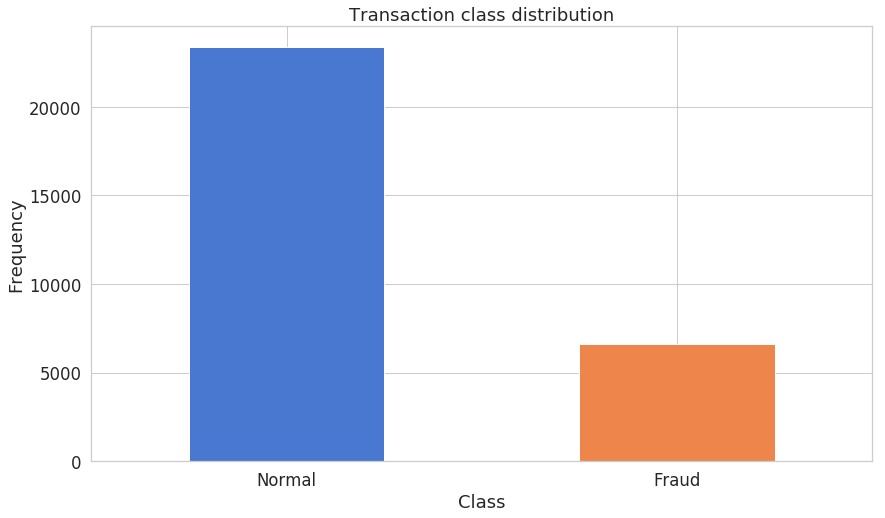

In [0]:
count_classes = pd.value_counts(df['target'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [0]:
frauds = df[df.target == 1]
normal = df[df.target == 0]

In [0]:
frauds.shape

(6636, 24)

In [0]:
normal.shape

(23364, 24)

# Preparing the data



In [0]:
from sklearn.preprocessing import StandardScaler


In [0]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.target == 0]
X_train = X_train.drop(['target'], axis=1)

y_test = X_test['target']
X_test = X_test.drop(['target'], axis=1)

X_train = X_train.values
X_test = X_test.values

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
X_train.shape

(18677, 23)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [0]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [0]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [0]:
nb_epoch = 20
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 18677 samples, validate on 6000 samples
Epoch 1/20
18677/18677 [==============================] - 3s 135us/step - loss: 0.4906 - acc: 0.5614 - val_loss: 0.4398 - val_acc: 0.5492
Epoch 2/20
18677/18677 [==============================] - 2s 124us/step - loss: 0.4829 - acc: 0.5596 - val_loss: 0.4334 - val_acc: 0.5570
Epoch 3/20
18677/18677 [==============================] - 2s 124us/step - loss: 0.4769 - acc: 0.5602 - val_loss: 0.4296 - val_acc: 0.5680
Epoch 4/20
18677/18677 [==============================] - 2s 115us/step - loss: 0.4719 - acc: 0.5609 - val_loss: 0.4248 - val_acc: 0.5698
Epoch 5/20
18677/18677 [==============================] - 2s 109us/step - loss: 0.4664 - acc: 0.5639 - val_loss: 0.4227 - val_acc: 0.5423
Epoch 6/20
18677/18677 [==============================] - 2s 110us/step - loss: 0.4621 - acc: 0.5639 - val_loss: 0.4188 - val_acc: 0.5632
Epoch 7/20
18677/18677 [==============================] - 2s 110us/step - loss: 0.4597 - acc: 0.5611 - val_loss: 0.4163 - v

In [0]:
autoencoder = load_model('model.h5')

# Evaluation

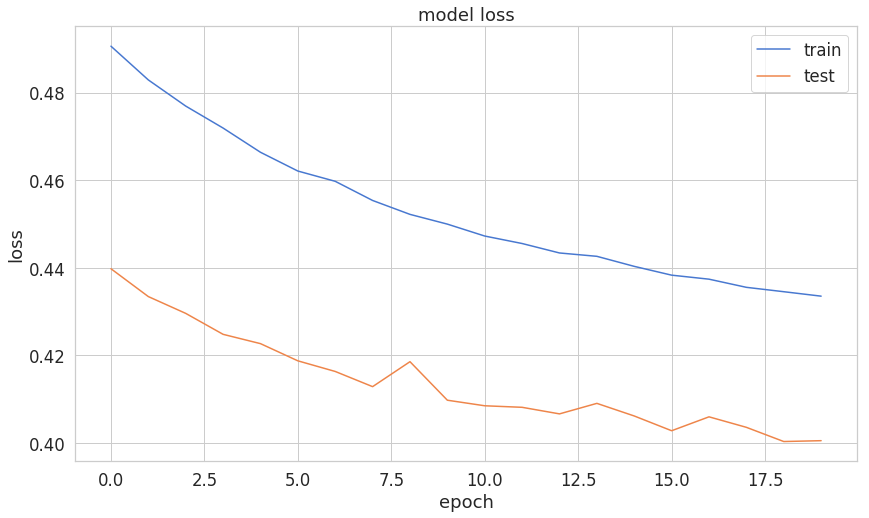

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [0]:
predictions = autoencoder.predict(X_test)

In [0]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

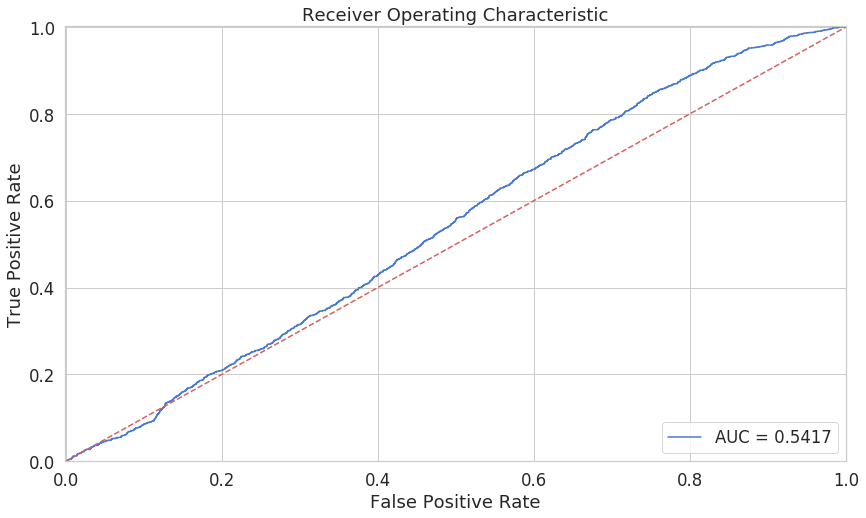

In [0]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

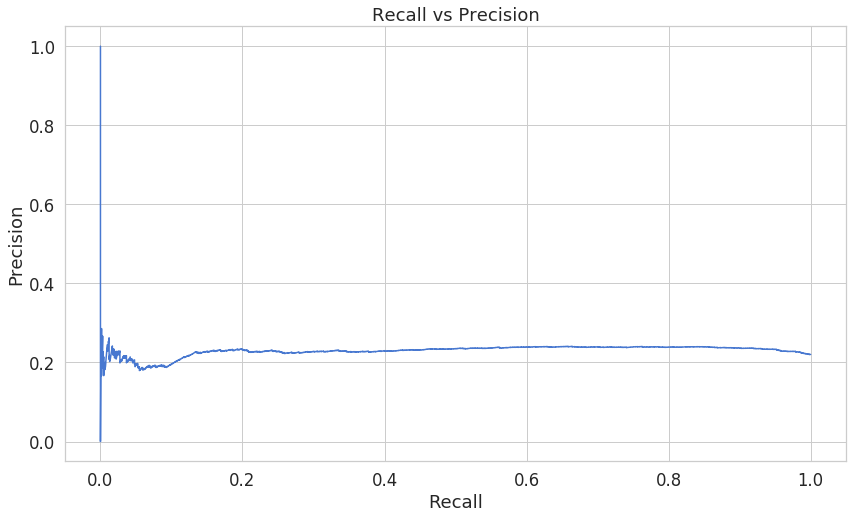

In [0]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

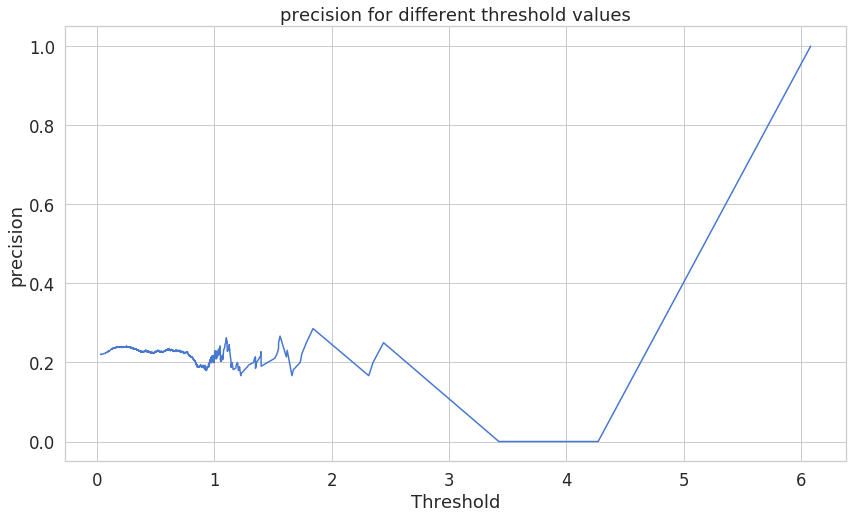

In [0]:
plt.plot(th, precision[1:], 'b', label='precision-Precision curve')
plt.title('precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

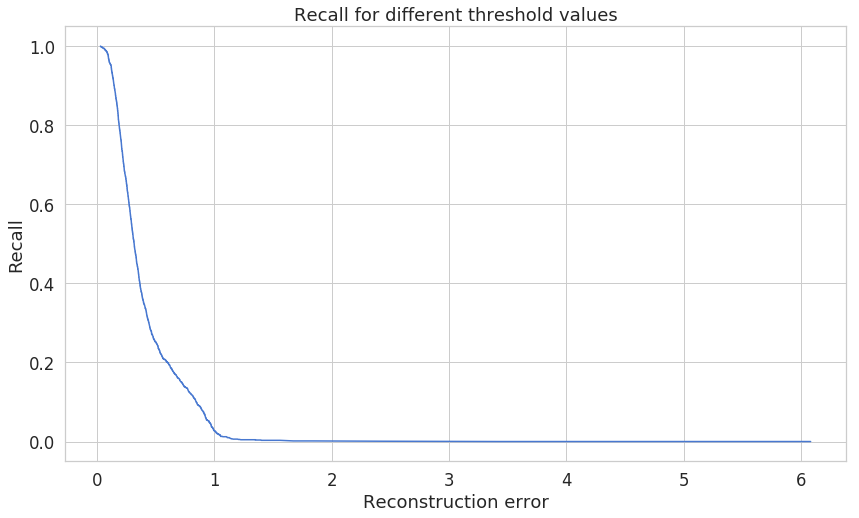

In [0]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

In [0]:
threshold = 0.1

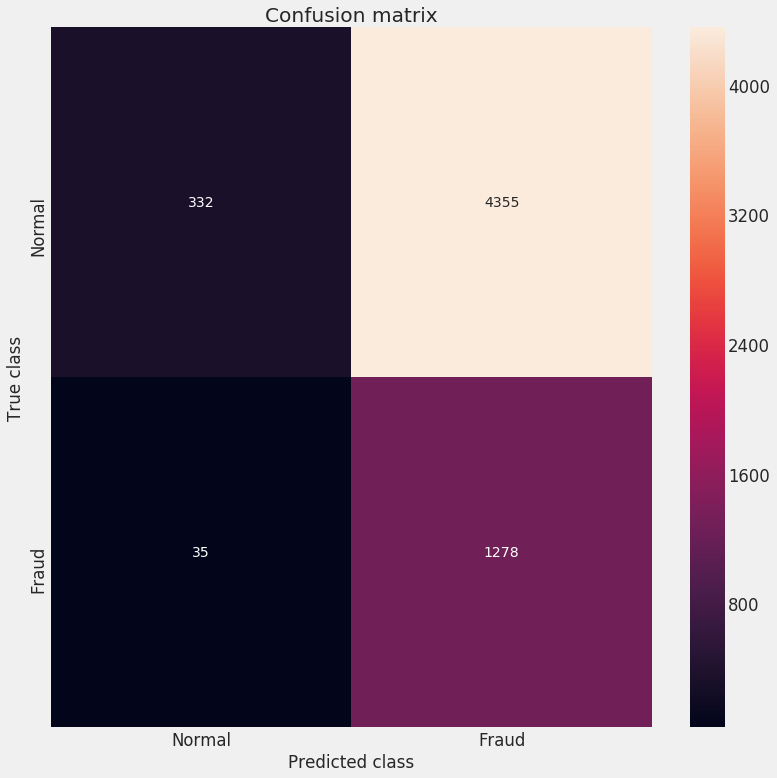

In [0]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
cm = confusion_matrix(error_df.true_class,y_pred)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
cost = 100*FN + 10*FP +1*TP
print('cost = ',cost)
hit_rate = TP/(TP+FP)
print("Precision = ",hit_rate)
Detection_Rate = TP / (TP + FN)
print('Recall = ',Detection_Rate)
print(classification_report(error_df.true_class,y_pred))

cost =  48328
Precision =  0.22687733001952778
Recall =  0.9733434881949733
              precision    recall  f1-score   support

           0       0.90      0.07      0.13      4687
           1       0.23      0.97      0.37      1313

   micro avg       0.27      0.27      0.27      6000
   macro avg       0.57      0.52      0.25      6000
weighted avg       0.76      0.27      0.18      6000



In [0]:
from sklearn.cluster import KMeans
from __future__ import print_function, division
from keras.models import Model
import tensorflow as tf 
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D
import pandas as pd 
from matplotlib import style
import pickle
import numpy as np 
from sklearn.externals import joblib

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D

style.use('fivethirtyeight')

plt.ion()  

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:23], df.iloc[:,23], test_size=0.3, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [0]:
#creating the encoder
input_layer = Input(shape=(23,))
## encoding architecture
encode_layer1 = Dense(20, activation='relu')(input_layer)
encode_layer2 = Dense(15, activation='relu')(encode_layer1)
encode_layer3 = Dense(10, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(23, activation='elu')(encode_layer3)

autoencoder = Model(input_layer,latent_view)

# this model maps an input to its encoded representation
encoder = Model(input_layer, encode_layer3)

autoencoder.compile(optimizer=keras.optimizers.RMSprop(lr=0.1), loss='binary_crossentropy')

autoencoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test ),verbose=1)



NameError: ignored

In [0]:
#extracting 10 features for train and test dataset
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)
encoded_test.shape

(9000, 10)

In [0]:
kmeans=KMeans(n_clusters=2,random_state=0,algorithm="elkan",max_iter=300, tol=0.001,n_jobs=-1)
kmeans.fit(encoded_train)
kmeans_predicted_train_labels=kmeans.predict(encoded_train)

In [0]:
tn,fp,fn,tp=confusion_matrix(y_train,kmeans_predicted_train_labels).ravel()

In [0]:
reassignflag=False
if tn+tp<fn+fp:
	# clustering is opposite of original classification
	reassignflag=True
kmeans_predicted_test_labels=kmeans.predict(encoded_test)
if reassignflag:
	kmeans_predicted_test_labels=1-kmeans_predicted_test_labels

In [0]:
tn,fp,fn,tp=confusion_matrix(y_test,kmeans_predicted_test_labels).ravel()

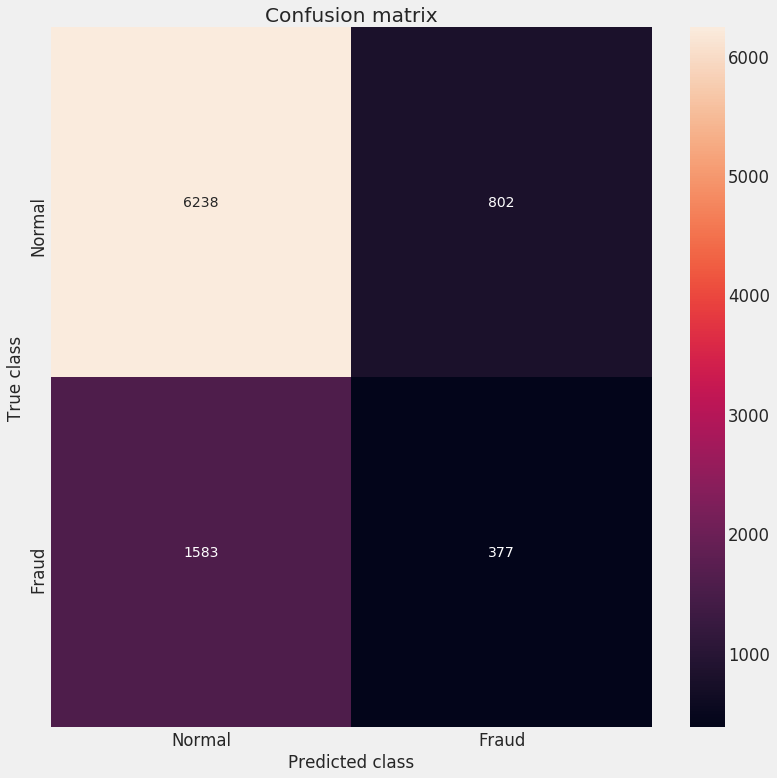

In [0]:
conf_matrix = confusion_matrix(y_test, kmeans_predicted_test_labels)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TP = conf_matrix[1][1]
hit_rate = TP/(TP+FP)
print("Precision = ",hit_rate)
Detection_Rate = TP / (TP + FN)
print('Recall = ',Detection_Rate)

Precision =  0.3197625106022053
Recall =  0.1923469387755102
